<a href="https://colab.research.google.com/github/0seoyeon/tobigs-21st/blob/%EA%B3%B5%EC%84%9C%EC%97%B0/Week2/Regression/%EA%B3%B5%EC%84%9C%EC%97%B0/Tobigs_Week2_regression_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [ ]:
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import re

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current directory:", current_directory) # /content

# 작업 디렉토리 내의 파일 목록 확인
# os.listdir(current_directory)

# 작업 디렉토리 변경
new_directory = os.chdir('/content/drive/MyDrive/Tobigs/regular_session')
current_directory = os.getcwd()
print('Current directory:', current_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/My Drive/Tobigs/regular_session
Current directory: /content/drive/MyDrive/Tobigs/regular_session


# Data

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction

< y >
* **Price** : The price of the used car in INR Lakhs.



< X >
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual) *transmission: 변속기
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC. *displacement volume: 배기 용적
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [ ]:
# Load Data
data = pd.read_csv("./data/assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [ ]:
data.shape

(6019, 14)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


# 결측치 처리
- Mileage는 2개, Engine, Power는 36개, Seats는 42개의 결측치를 가지고 있는데, 이는 전체 데이터셋 크기의 1% 미만을 차지하므로 인스턴스 단위로 결측치를 제거하였다.
- 반면 New_Price의 결측치는 5195개로 전체 데이터셋 크기의 약 86%에 육박하므로 인스턴스를 제거하기보다는 New_Price 피처 자체를 제거하였다.

In [ ]:
# 결측치 포함하는 행(인스턴스) drop하는 경우: Mileage, Engine, Power, Seats
cleaned_data = data.drop(index=data[data['Mileage'].isna() | data['Engine'].isna() | data['Power'].isna() | data['Seats'].isna()].index.tolist())

# 결측치 포함하는 열(피처) drop하는 경우: New_Price
cleaned_data = cleaned_data.drop(columns='New_Price')

# 결과 확인
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5975 non-null   int64  
 1   Name               5975 non-null   object 
 2   Location           5975 non-null   object 
 3   Year               5975 non-null   int64  
 4   Kilometers_Driven  5975 non-null   int64  
 5   Fuel_Type          5975 non-null   object 
 6   Transmission       5975 non-null   object 
 7   Owner_Type         5975 non-null   object 
 8   Mileage            5975 non-null   object 
 9   Engine             5975 non-null   object 
 10  Power              5975 non-null   object 
 11  Seats              5975 non-null   float64
 12  Price              5975 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 653.5+ KB


# 이상치 처리
Zscore 기준으로 이상치를 탐지하고 처리하였다.

In [ ]:
def outlier_by_Zscore(data):
  # z_score 구하기
  mean = np.mean(data)
  std = np.std(data)
  z_scores = (data - mean) / std

  # outlier로 처리할 임계 z_score 값을 3으로 설정
  # outlier 확인
  z_score_outliers = z_scores[(z_scores > 3) | (z_scores < -3)]

  return z_score_outliers

In [ ]:
# 이상치 탐지
outliers = outlier_by_Zscore(cleaned_data)
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Engine             0 non-null      object 
 1   Fuel_Type          0 non-null      object 
 2   Kilometers_Driven  7 non-null      float64
 3   Location           0 non-null      object 
 4   Mileage            0 non-null      object 
 5   Name               0 non-null      object 
 6   Owner_Type         0 non-null      object 
 7   Power              0 non-null      object 
 8   Price              149 non-null    float64
 9   Seats              159 non-null    float64
 10  Transmission       0 non-null      object 
 11  Unnamed: 0         0 non-null      float64
 12  Year               46 non-null     float64
dtypes: float64(5), object(8)
memory usage: 653.5+ KB


In [ ]:
# 이상치가 존재하는 인스턴스를 제거
cleaned_data = cleaned_data.drop(index=outliers.dropna(how='all', axis=0).index.tolist())

# 결과 확인
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5627 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5627 non-null   int64  
 1   Name               5627 non-null   object 
 2   Location           5627 non-null   object 
 3   Year               5627 non-null   int64  
 4   Kilometers_Driven  5627 non-null   int64  
 5   Fuel_Type          5627 non-null   object 
 6   Transmission       5627 non-null   object 
 7   Owner_Type         5627 non-null   object 
 8   Mileage            5627 non-null   object 
 9   Engine             5627 non-null   object 
 10  Power              5627 non-null   object 
 11  Seats              5627 non-null   float64
 12  Price              5627 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 615.5+ KB


# 데이터 단위 변환
Mileage, Engine, Power은 자료형이 object이지만 수치형 변수의 특성을 가지고 있으므로 단위(km/kg(kmpl), CC, bhp)를 제거해서 수치형 변수로 변환한다.


In [ ]:
# 단위(km/kg, kmpl, CC, bhp) 제거
for col in ['Mileage', 'Engine', 'Power']:
  cleaned_data[col] = cleaned_data[col].str.replace(r'(km/kg|kmpl|CC|bhp)', '', regex=True) # 주의 r'km/kg | kmpl|'처럼 OR 기호 사이에 띄어쓰기 하지 말 것
  # cleaned_data[col] = pd.to_numeric(cleaned_data[col]) # "null " 발견

  cleaned_data = cleaned_data.drop(index=cleaned_data[cleaned_data[col] == "null "].index.tolist())

  cleaned_data[col] = pd.to_numeric(cleaned_data[col])

# 결과 확인
cleaned_data.head(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998,58.16,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.20,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199,88.70,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968,140.80,5.0,17.74


# 인코딩 (Encoding)
범주형 변수를 수치형 변수로 인코딩해야 회귀 모형에 적용할 수 있다.

In [ ]:
cat_data = cleaned_data.select_dtypes(include='object').columns.tolist()
cat_data

['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

In [ ]:
encoder = LabelEncoder()

for col in cat_data:
  cleaned_data[col] = encoder.fit_transform(cleaned_data[col])

# 결과 확인
cleaned_data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,1062,9,2010,72000,0,1,0,26.60,998,58.16,5.0,1.75
1,1,465,10,2015,41000,1,1,0,19.67,1582,126.20,5.0,12.50
2,2,439,2,2011,46000,3,1,0,18.20,1199,88.70,5.0,4.50
3,3,933,2,2012,87000,1,1,0,20.77,1248,88.76,7.0,6.00
4,4,21,3,2013,40670,1,0,2,15.20,1968,140.80,5.0,17.74


# 학습/테스트 데이터셋 분리
Train/Test split

In [ ]:
# 인덱스 열 (Unnamed: 0) 제거
cleaned_data = cleaned_data.drop('Unnamed: 0', axis=1)

In [ ]:
X = cleaned_data.drop('Price', axis=1) # Independet variable
y = cleaned_data['Price'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

# 데이터 단위 조정(Scaling)
Scaling: 피처별 편차와 크기가 다를 경우 특정 피처의 특성에만 의존하는 모델으로 학습될 수 있으므로 scaler를 통해 표준화해준다.

In [ ]:
# Scaling
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) # 학습 데이터셋에 대해 fit한 scaler로 테스트 데이터셋을 스케일링

# 결과 확인
X_train.head(3), X_test.head(3)

(       Name  Location      Year  Kilometers_Driven  Fuel_Type  Transmission  \
 0  0.479395 -1.251115 -0.497331          -0.450567   1.049114      0.622013   
 1  0.990570  0.447221  0.488427           0.594589  -0.928180      0.622013   
 2  0.305423  0.107554 -0.825916           0.698570  -0.928180      0.622013   
 
    Owner_Type   Mileage    Engine     Power     Seats  
 0    3.317795  0.007803 -0.675094 -0.480877 -0.331113  
 1   -0.449849  0.101982 -0.190822 -0.004352 -0.331113  
 2   -0.449849  0.582068 -0.581542 -0.731237 -0.331113  ,
        Name  Location      Year  Kilometers_Driven  Fuel_Type  Transmission  \
 0 -1.232400 -1.251115 -2.140260           1.339559   1.049114      0.622013   
 1 -0.006008 -1.251115 -0.168745           0.660546  -0.928180      0.622013   
 2 -1.406372 -0.911448 -1.811674           0.788941  -0.928180      0.622013   
 
    Owner_Type   Mileage    Engine     Power     Seats  
 0   -0.449849 -0.451609 -0.324730 -0.855365 -0.331113  
 1   -0.44984

In [ ]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((3875, 11), (1662, 11), (3875,), (1662,))

# 모델 학습

In [ ]:
# Scikit Learn module
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1은 scikit learn이 자동으로 추가해준다.

#Parameter
theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = pd.Series(theta, name='theta by SkLearn')
parameter_df

0     8.173858
1    -0.078898
2    -0.523754
3     2.276377
4    -0.780782
5    -1.788166
6    -1.384878
7    -0.068225
8    -1.230107
9    -0.222384
10    3.991033
11   -0.139630
Name: theta by SkLearn, dtype: float64

# 모델 평가

In [ ]:
y_pred = lin_reg.predict(X_test) # sklearn linear regression 모델을 이용한 예측값

In [ ]:
# MSE
MSE = mean_squared_error(y_pred, y_test)

# R^2
R_squared = lin_reg.score(X_test, y_test)

print(f'MSE: {MSE}\nR_squred: {R_squared}')

MSE: 19.251211157668816
R_squred: 0.7407882480487304


# 회귀 진단
- 독립변수와 종속변수 간의 선형 관계
- 오차의 정규성
- 오차의 등분산성
- 오차의 독립성
- 다중공선성

In [ ]:
11
1 - 11/4()

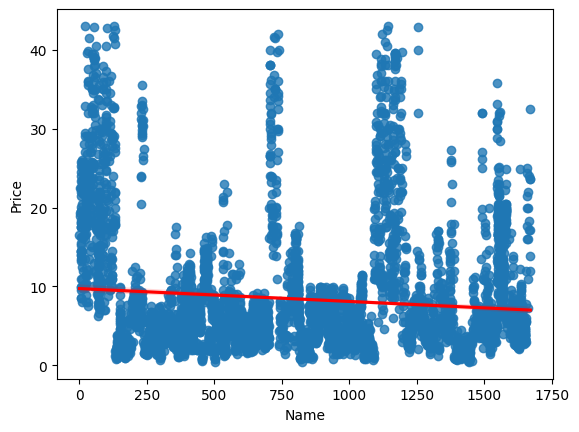

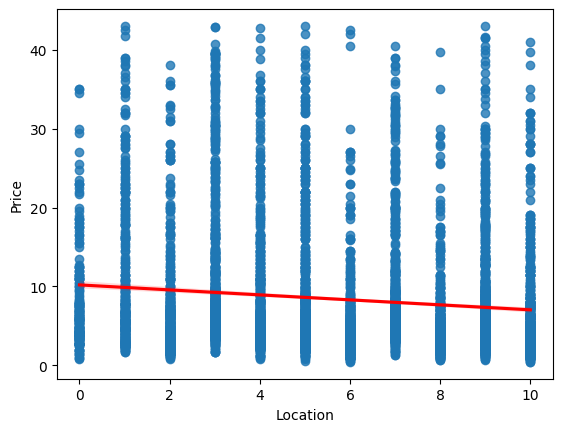

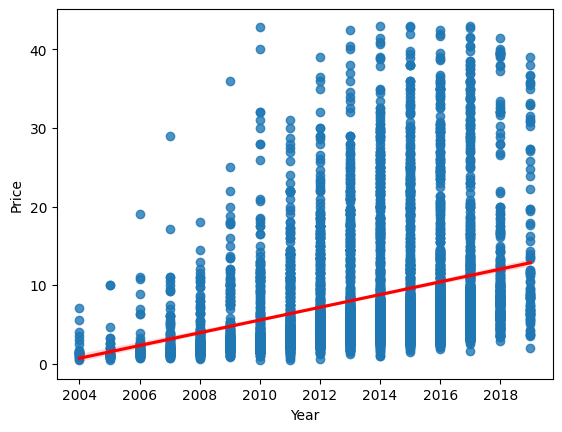

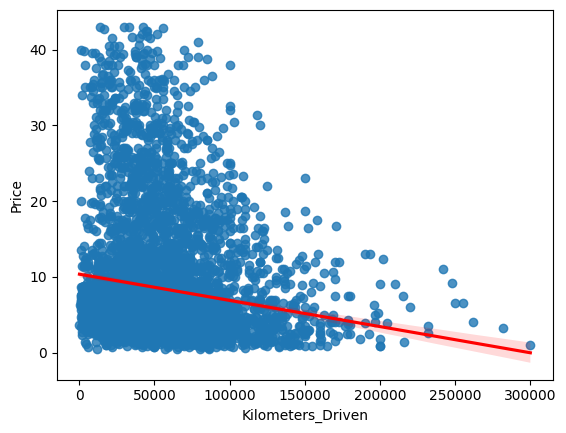

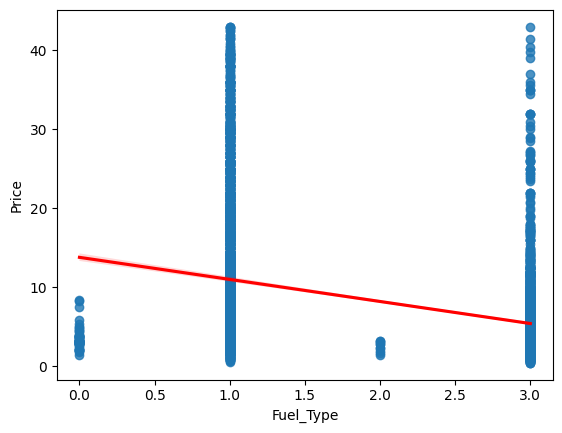

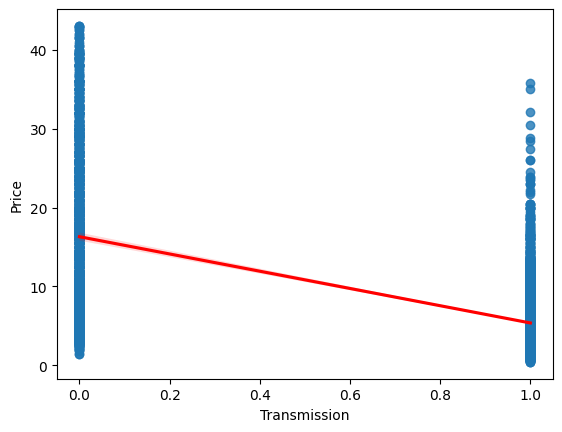

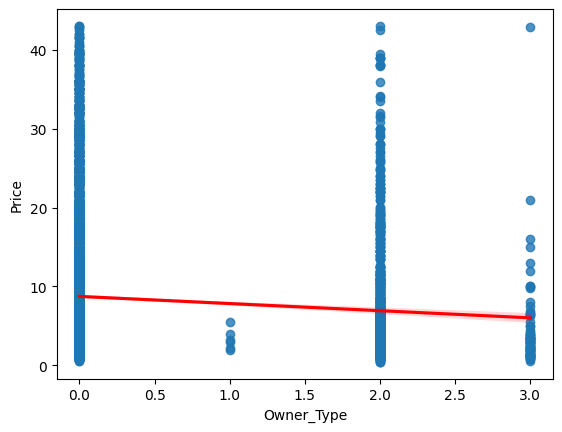

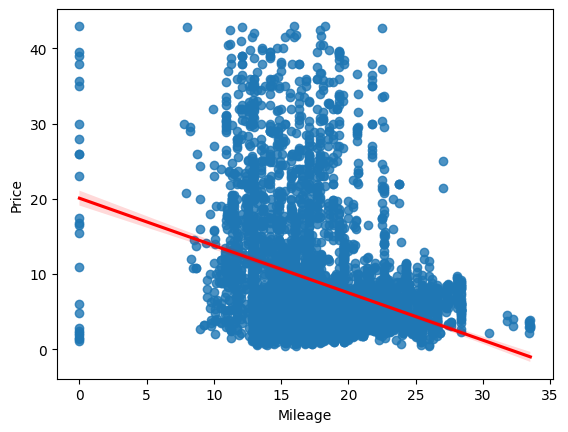

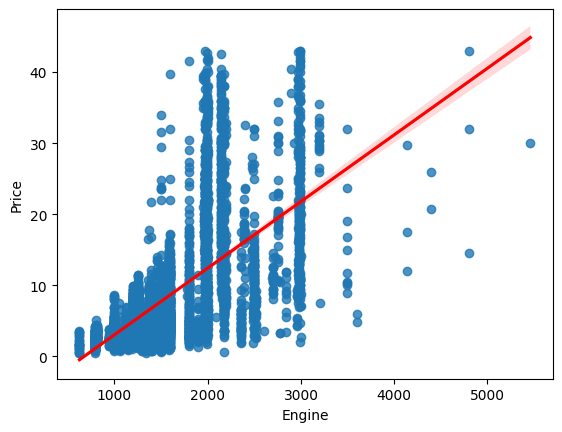

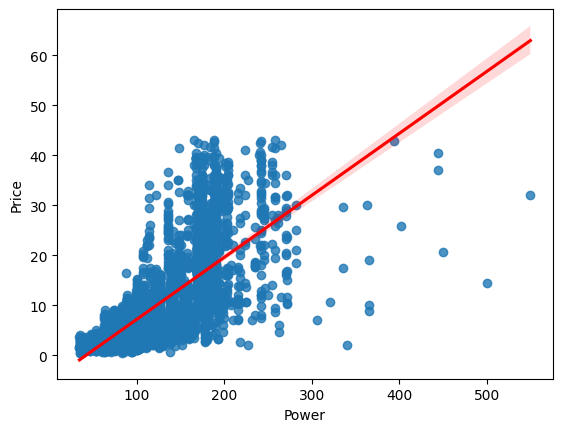

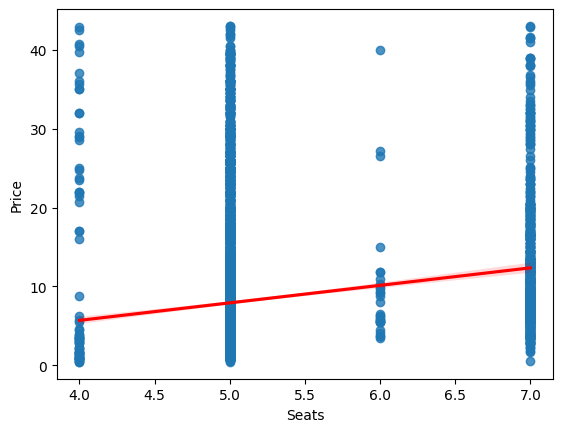

In [ ]:
# 선형성
for col in X.columns:
    sns.regplot(x=X[col], y=y, line_kws={"color": "red"})
    plt.show()


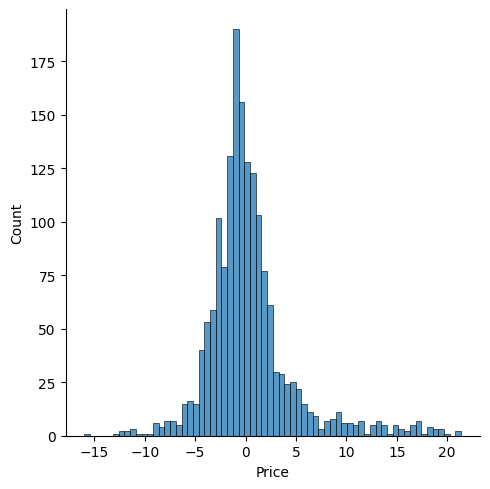

In [ ]:
# 정규성
f = sns.displot((y_test - y_pred))

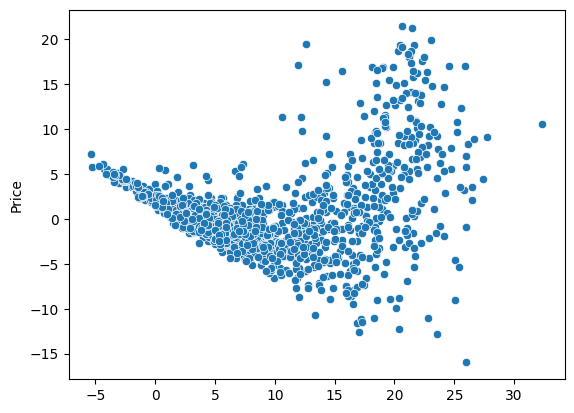

In [ ]:
# 등분산성 확인
f = sns.scatterplot(y=(y_test - y_pred), x = y_pred)

In [ ]:
# 다중공선성1
# VTR이 10 미만이므로 다중 공선성 없다고 판단
VTF = 1/(1- R_squared)
VTF

3.8578497790794404

<Axes: >

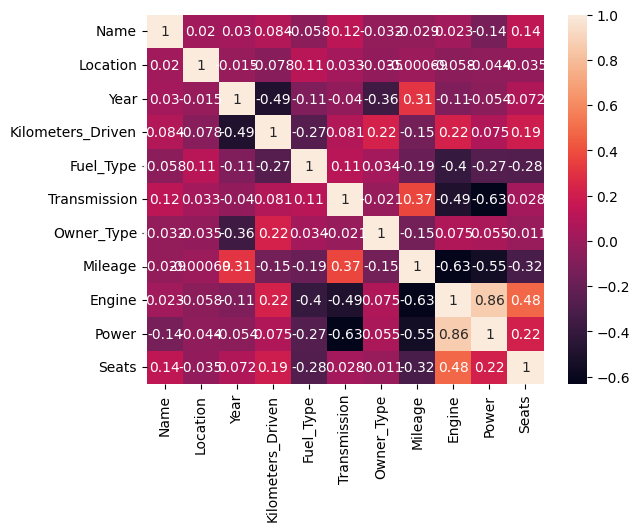

In [ ]:
# 다중공선성2
# 상관계수 행렬 확인 결과, Engine과 Power의 상관이 높았다.
sns.heatmap(X.corr(), annot=True)

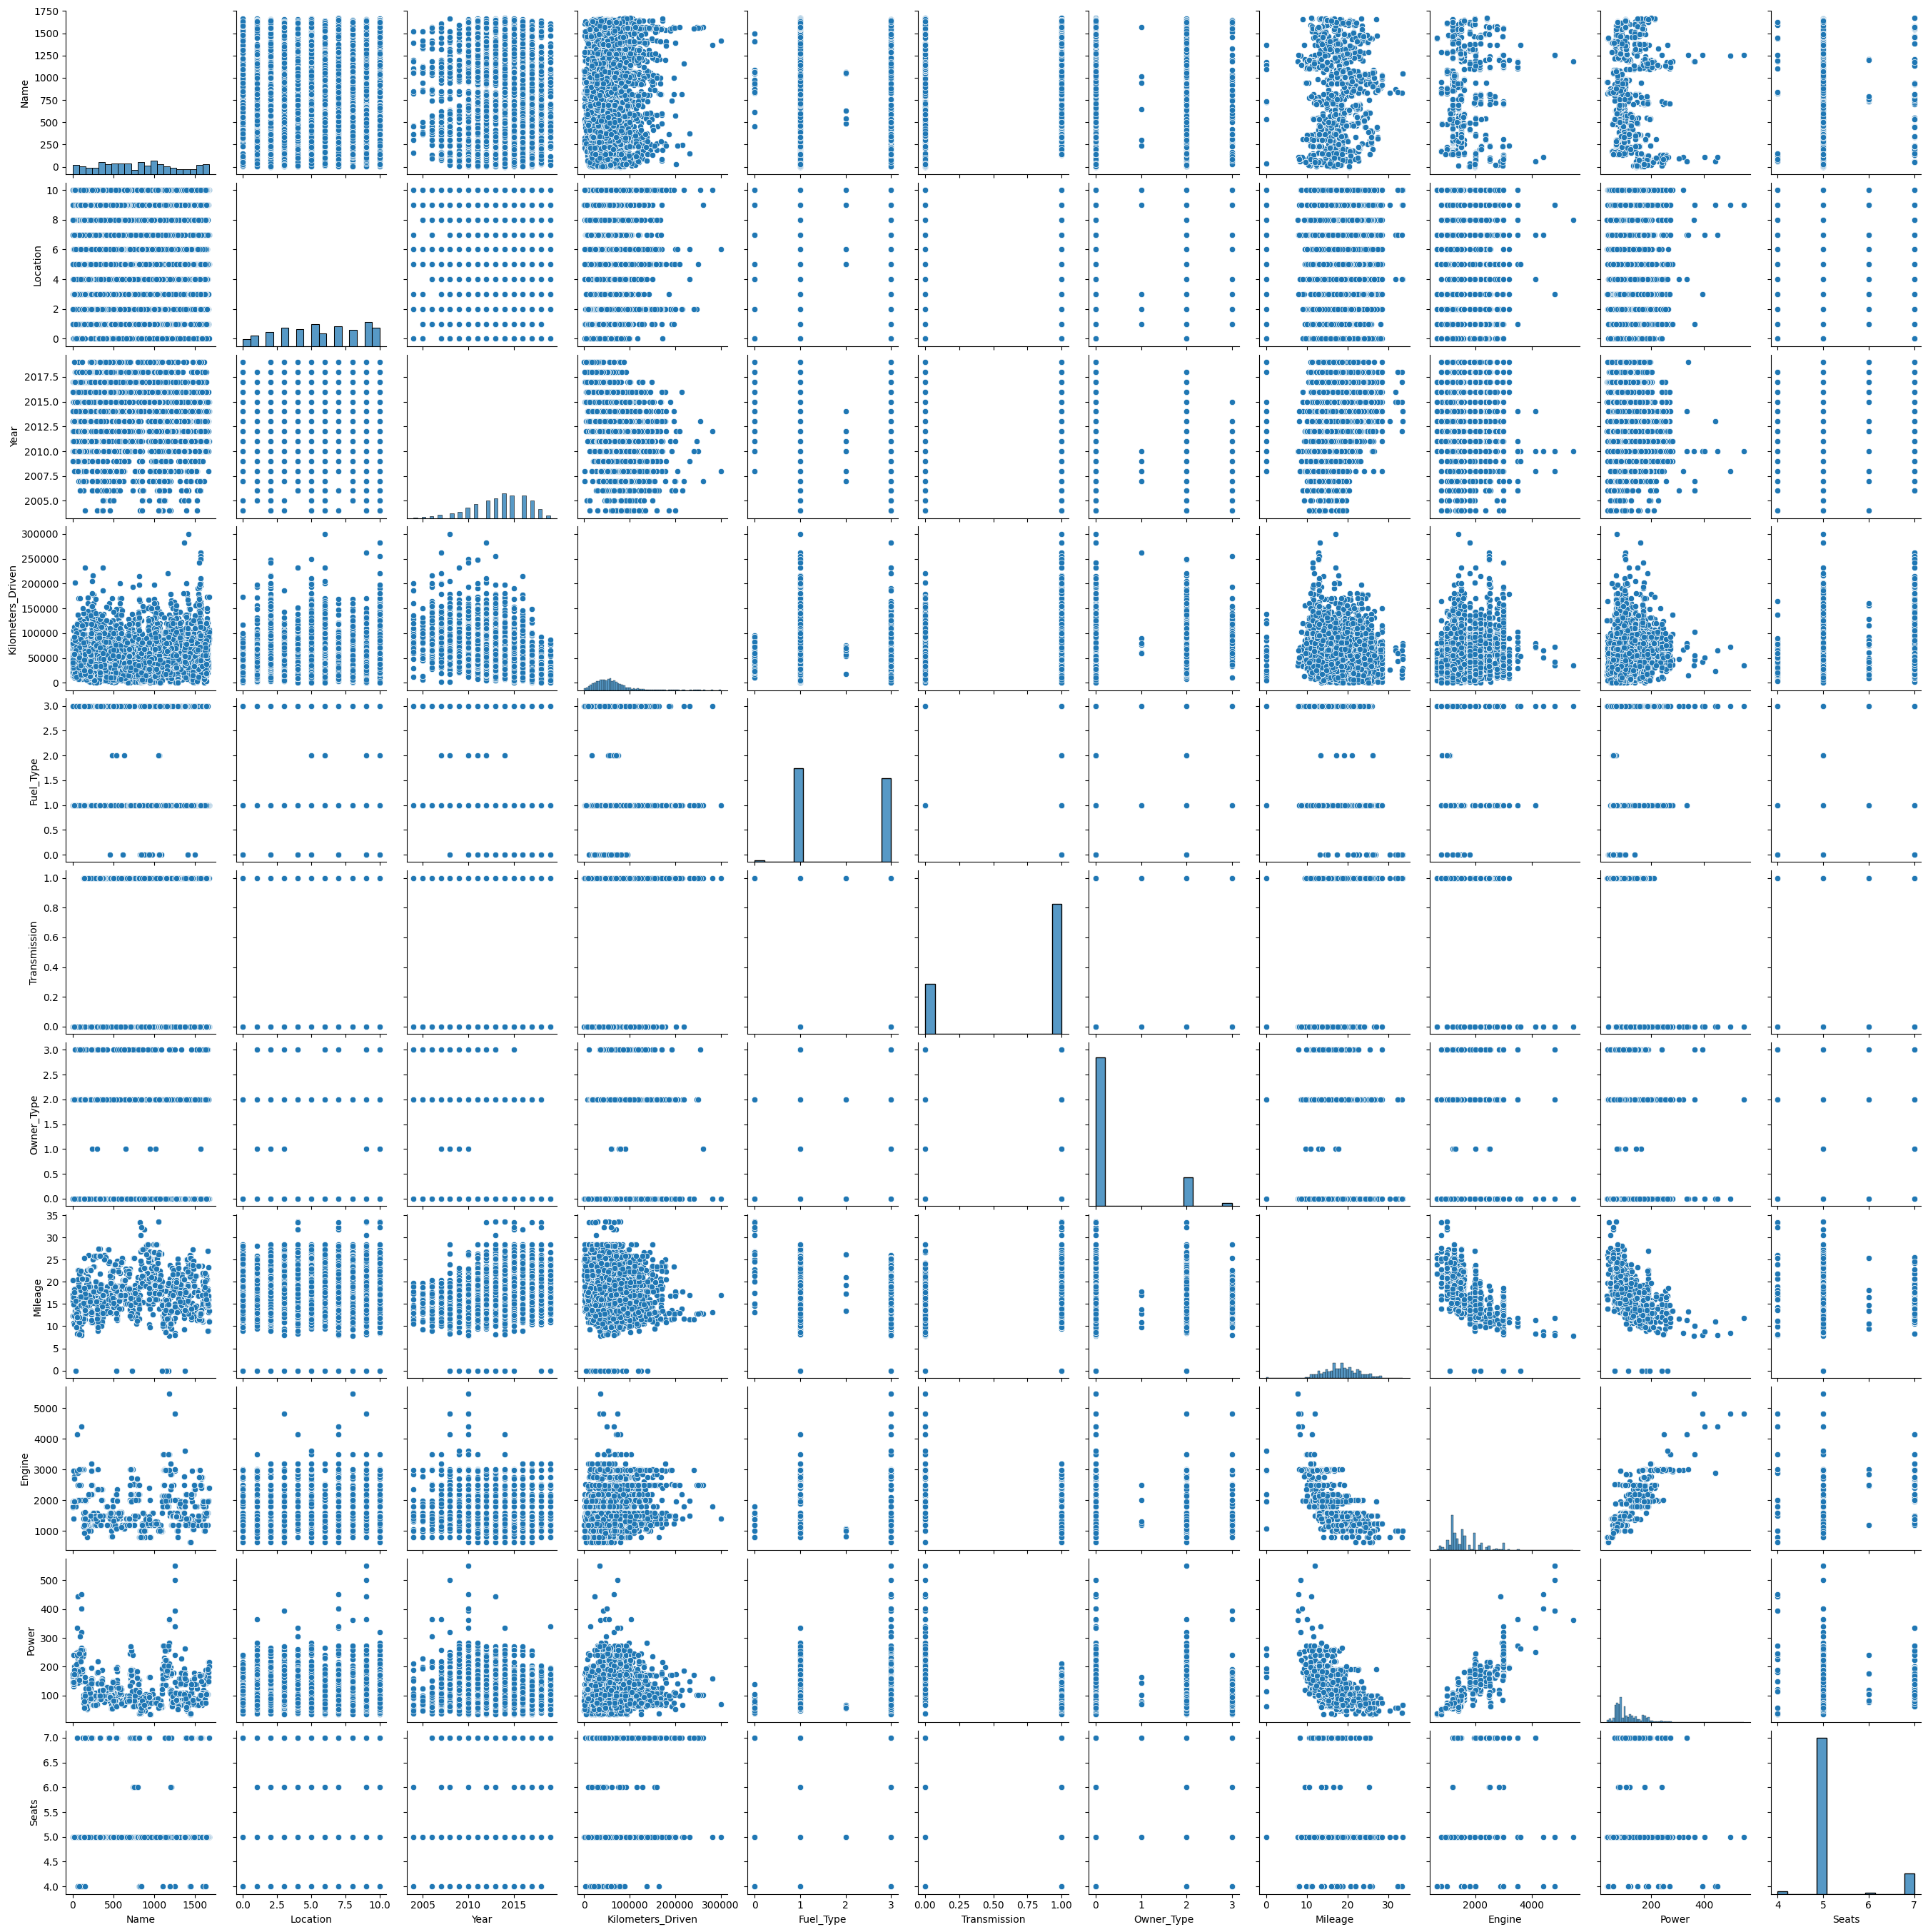

In [ ]:
# 다중공선성 3
# 산점도 행렬 확인 결과, Engine-Power, Mileage-Engie, Mileage-Power 간 상관 관계가 있는 것을 발견했다.
sns.pairplot(X)